# Mini project 1
## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import SGD, Adam
%matplotlib inline

from sklearn.metrics import classification_report

Using TensorFlow backend.


### Data generation functions

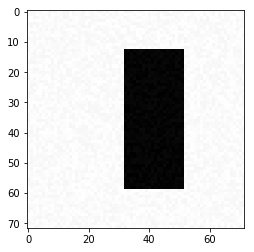

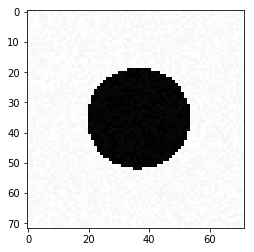

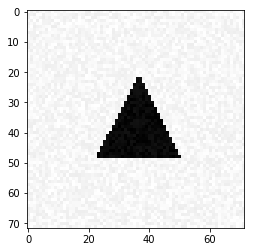

In [2]:
#%% Defining data generating functions
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

#%% Printing data samples
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(72,72), cmap='gray')
plt.show()

im = generate_a_disk(10)
plt.imshow(im.reshape(72,72), cmap='gray')
plt.show()

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(72,72), cmap='gray')
plt.show()
#%% Defining dataset generators

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    #print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
        #    print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    #print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
        #    print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((72,72))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

Their appears to be a problem with the test set regression function

In [3]:
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    #Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

### 2. Simple classification

#### Importing training data

In [4]:
#%% Defining training and test data

[X_train, Y_train] = generate_dataset_classification(600, 20)
[X_test, Y_test] = generate_test_set_classification()

Y_train_cat = np_utils.to_categorical(Y_train)

In [5]:
K.clear_session()

# function to generate simple linear models
def generate_linear_model(X_train = X_train, nb_neurons = 40, opt = 'adam'):
    model = Sequential()
    model.add(Dense(nb_neurons, input_shape = (X_train.shape[1],), activation = 'relu'))
    model.add(Dense(3, activation = 'softmax'))
    model.summary()
    
    model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer=opt)
    
    return model

In [6]:
# Defining optimizers
adam = Adam(lr = .0001)
sgd = SGD(lr = .0001)
# Choosing a number of neurons for the hidden layer
nb_neurons = 20

In [7]:
# Creating two Neural Networks with Adam and SGD optimizers
linear_model_adam = generate_linear_model(opt = adam, nb_neurons= 20)
linear_model_sgd = generate_linear_model(opt = sgd, nb_neurons = 20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                103700    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 63        
Total params: 103,763
Trainable params: 103,763
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                103700    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 63        
Total params: 103,763
Trainable params: 103,763
Non-trainable params: 0
_________________________________________________________________


####  Fitting the training data 

In [8]:
linear_model_sgd.fit(X_train, Y_train_cat, epochs = 100,
                     batch_size = 32, verbose =0)

linear_model_adam.fit(X_train, Y_train_cat, epochs = 100, 
                      batch_size = 32, verbose = 0)

#### Measuring performances on test set

In [9]:
#%% Printing resuslts
predictions_adam = np_utils.to_categorical(linear_model_adam.predict_classes(X_test))
predictions_sgd = np_utils.to_categorical(linear_model_sgd.predict_classes(X_test))

print("\nADAM Optimizer", "\n",classification_report(Y_test, predictions_adam))
print("\nSGD  Optimizer", "\n",classification_report(Y_test, predictions_sgd))


ADAM Optimizer 
              precision    recall  f1-score   support

          0       0.21      0.08      0.11       102
          1       0.40      0.37      0.39        99
          2       0.37      0.63      0.46        99

avg / total       0.32      0.36      0.32       300


SGD  Optimizer 
              precision    recall  f1-score   support

          0       0.35      0.06      0.10       102
          1       0.36      0.40      0.38        99
          2       0.35      0.61      0.44        99

avg / total       0.35      0.35      0.31       300



### 3. Visualizing wieghts

ADAM Optimizers


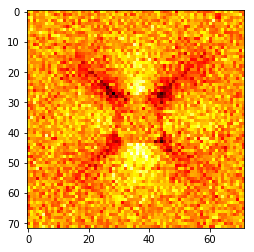

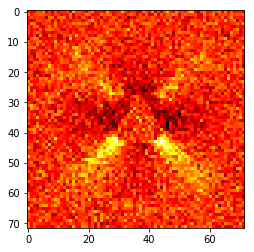

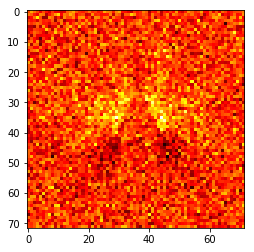

SGD Optimizers


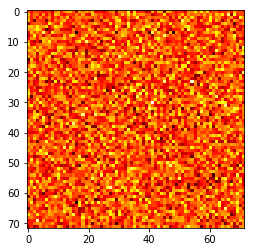

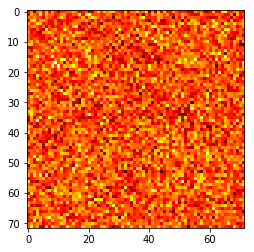

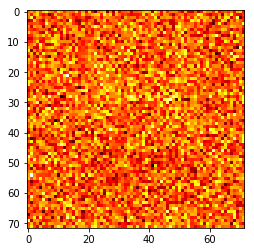

In [10]:
weights1_adam = np.array(linear_model_adam.get_weights()[0]).reshape(72,72,nb_neurons)
weights2_adam = np.array(linear_model_adam.get_weights()[2])
total_weights_adam = np.dot(weights1_adam, weights2_adam)

weights1_sgd = np.array(linear_model_sgd.get_weights()[0]).reshape(72,72,nb_neurons)
weights2_sgd = np.array(linear_model_sgd.get_weights()[2])
total_weights_sgd = np.dot(weights1_sgd, weights2_sgd)

#%%
print('ADAM Optimizers')
for i in range(3):
    plt.imshow(total_weights_adam[:,:,i],cmap = 'hot')
    plt.show()
print('SGD Optimizers')
for i in range(3):
    plt.imshow(total_weights_sgd[:,:,i],cmap = 'hot')
    plt.show()

We can see a clear difference between SGD and Adam optimizers: Adam seems to have caught some insights about the place where the features are important. 

### 4. Moves are allowed to move

In [11]:
# Definition of the new training and test data
[X_train_c, Y_train_c] = generate_dataset_classification(600, 20, True)
[X_test_c, Y_test_c] = generate_test_set_classification()

Y_train_c = np_utils.to_categorical(Y_train_c)

In [12]:
linear_model_sgd.fit(X_train_c, Y_train_c, epochs = 100,
                     batch_size = 32, verbose = 0)

linear_model_adam.fit(X_train_c, Y_train_c, epochs = 100, 
                      batch_size = 32, verbose = 0)


print('\nADAM Optimizer\n', linear_model_adam.evaluate(X_test_c, Y_test_c))
print('\nSGD  Optimizer\n', linear_model_sgd.evaluate(X_test_c, Y_test_c))

300/300 [==============================] - 0s 613us/step

ADAM Optimizer
 [0.86442246039708459, 0.61333333253860478]
300/300 [==============================] - 0s 176us/step

SGD  Optimizer
 [0.92039622624715167, 0.52333333293596906]


In [13]:
#%% Printing resuslts
predictions_adam_c = np_utils.to_categorical(linear_model_adam.predict_classes(X_test_c))
predictions_sgd_c = np_utils.to_categorical(linear_model_sgd.predict_classes(X_test_c))

print("\nADAM Optimizer", "\n",classification_report(Y_test_c, predictions_adam_c))
print("\nSGD  Optimizer", "\n",classification_report(Y_test_c, predictions_sgd_c))


ADAM Optimizer 
              precision    recall  f1-score   support

          0       0.50      0.03      0.06       102
          1       0.80      0.91      0.85        99
          2       0.50      0.92      0.65        99

avg / total       0.60      0.61      0.51       300


SGD  Optimizer 
              precision    recall  f1-score   support

          0       0.47      0.28      0.35       102
          1       0.78      0.63      0.70        99
          2       0.42      0.67      0.51        99

avg / total       0.56      0.52      0.52       300



#### Implementation of a Convolutionnal Network

In [14]:
X_train_c = X_train_c.reshape(-1, 72, 72, 1)
X_test_c = X_test_c.reshape(-1, 72, 72, 1)

In [15]:
#%% Defining a classifier
K.clear_session()
classifier = Sequential()

classifier.add(Conv2D(16, kernel_size=(5,5), input_shape = (X_train_c.shape[1], X_train_c.shape[2],1), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Flatten())
classifier.add(Dropout(.25))
classifier.add(Dense(20, activation = 'relu'))
classifier.add(Dense(3, activation = 'softmax'))

In [16]:
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [17]:
classifier.fit(X_train_c, Y_train_c, epochs = 100, batch_size = 32, verbose = 0)

#### Measuring perfomances 

In [18]:
#%% Printing resuslts
predictions_adam = np_utils.to_categorical(classifier.predict_classes(X_test_c))

print("\nADAM Optimizer", "\n",classification_report(Y_test, predictions_adam))
print("\nSGD  Optimizer", "\n",classification_report(Y_test, predictions_sgd))


ADAM Optimizer 
              precision    recall  f1-score   support

          0       0.67      0.69      0.68       102
          1       0.86      0.84      0.85        99
          2       0.75      0.75      0.75        99

avg / total       0.76      0.76      0.76       300


SGD  Optimizer 
              precision    recall  f1-score   support

          0       0.35      0.06      0.10       102
          1       0.36      0.40      0.38        99
          2       0.35      0.61      0.44        99

avg / total       0.35      0.35      0.31       300



### 5. Regression with ConvNets

In [19]:
[X_train_r, Y_train_r] = generate_dataset_regression(3000, 20)
X_train_r = X_train_r.reshape(-1, 72, 72, 1)

In [20]:
[X_test_r, Y_test_r] = generate_test_set_regression()

In [22]:
X_test_r = X_test_r.reshape(-1, 72, 72, 1)

#### Normalization method
We are going to take the center of gravity of the triangles as a component of our target.
The two other components of our target is are going to be the coordinates of the vectors from the center of gravity to the most right vertex and to the most left vertex.

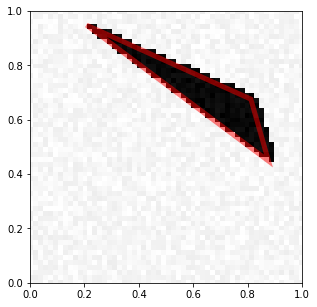

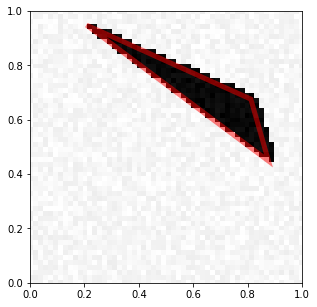

In [24]:
def generate_new_features(Y_train):
    gravity_centres = np.array([np.mean(Y_train[:,[0,2,4]], axis = 1),np.mean(Y_train[:,[1,3,5]], axis = 1)]).T
    
    A = Y_train[:,0:2] - gravity_centres
    B = Y_train[:,2:4] - gravity_centres
    C = Y_train[:,4:6] - gravity_centres
    
    new_data = np.concatenate([A,B,C], axis = 1)
    
    distances_max = np.argmax(new_data[:,[0,2,4]], axis = 1)*2
    distances_min = np.argmin(new_data[:,[0,2,4]], axis = 1)*2
    distances_autres = 6 - distances_max-distances_min
    right_vectors = [[new_data[i,distances_max[i]], new_data[i,distances_max[i]+1]] for i in range(Y_train.shape[0])]
    left_vectors  = [[new_data[i,distances_min[i]], new_data[i,distances_min[i]+1]] for i in range(Y_train.shape[0])]
    other = [[new_data[i,distances_autres[i]], new_data[i,distances_autres[i]+1]] for i in range(Y_train.shape[0])]
    final_data = np.concatenate([gravity_centres, right_vectors, left_vectors], axis = 1).reshape(-1, 6)
    
    return final_data


def recreate_features(Y_train_transformed):
    
    gravity_centres = Y_train_transformed[:,:2]
    right = Y_train_transformed[:,2:4] + gravity_centres
    left = Y_train_transformed[:,4:6] + gravity_centres
    #third = Y_train_transformed[:,6:8] + gravity_centres
    third =gravity_centres*3 - right -left
    
    return np.concatenate([right, left, third], axis = 1)

visualize_prediction(X_train_r[0], Y_train_r[0])
visualize_prediction(X_train_r[0], recreate_features(generate_new_features(Y_train_r[[0]])))

In [25]:
regressor = Sequential()
regressor.add(Conv2D(16, kernel_size=(5,5), input_shape = (X_train_r.shape[1], X_train_r.shape[2], 1), activation = 'relu'))
regressor.add(MaxPooling2D(pool_size=(2,2)))
regressor.add(Flatten())
regressor.add(Dropout(.25))
regressor.add(Dense(20, activation = "relu"))
regressor.add(Dense(6))
#%% Compiling regressor

regressor.compile(optimizer = Adam(lr = .0001), loss = 'mse')

In [34]:
regressor.fit(X_train_r, generate_new_features(Y_train_r), batch_size = 16, epochs = 100, verbose = 0)

#### Visualizing results

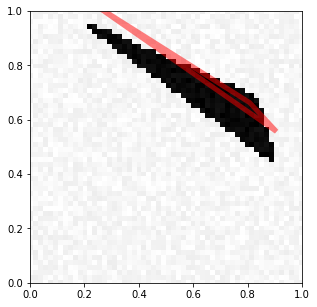

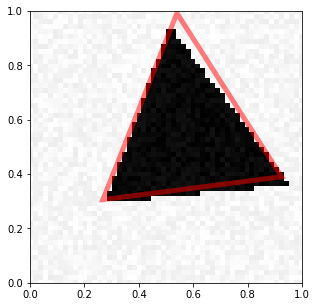

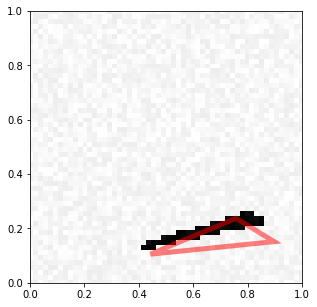

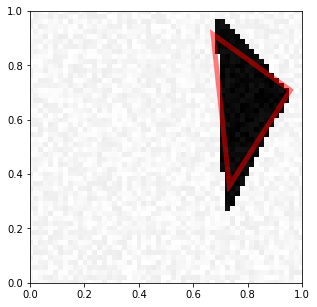

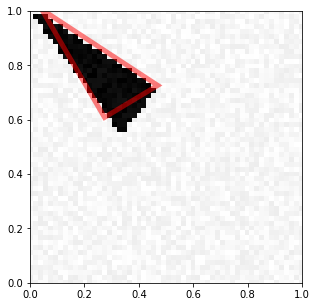

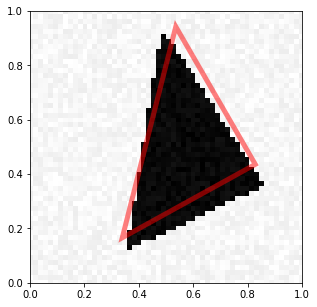

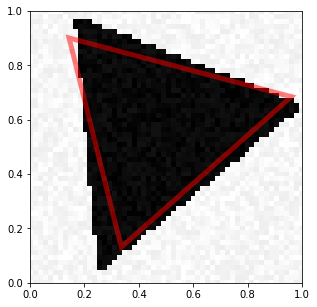

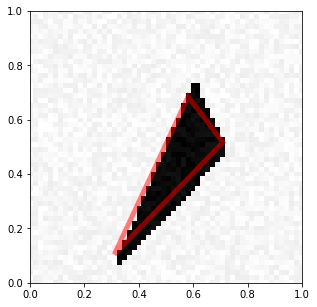

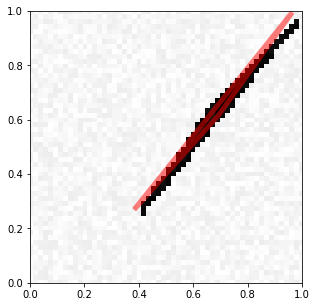

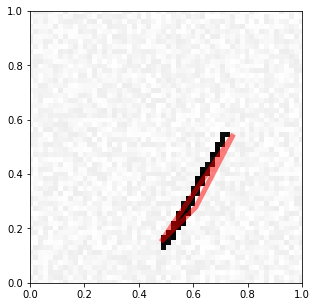

In [35]:
for i in range(10):
    visualize_prediction(X_train_r[i], recreate_features(regressor.predict(X_train_r[i].reshape(-1,72,72,1))))

In [36]:
predictions_regression = recreate_features(regressor.predict(X_test_r))

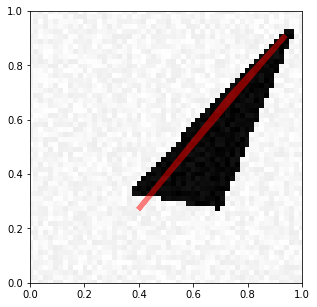

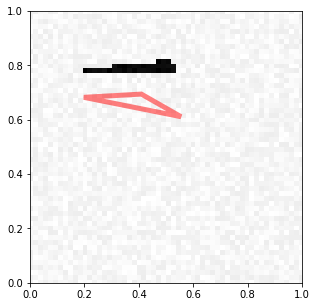

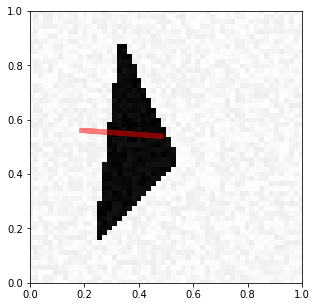

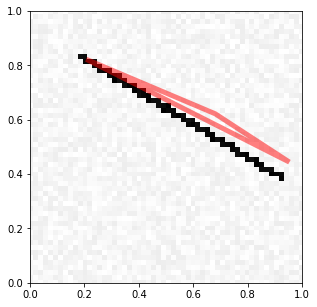

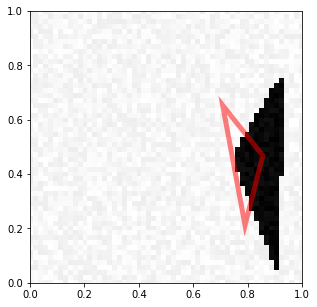

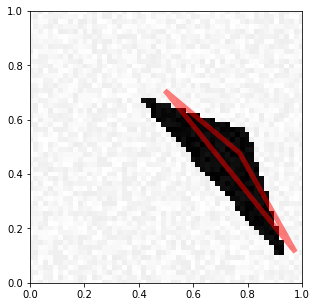

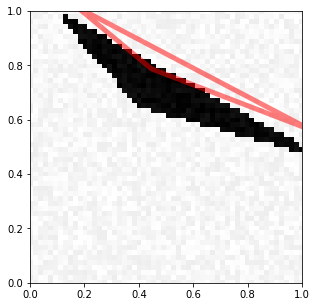

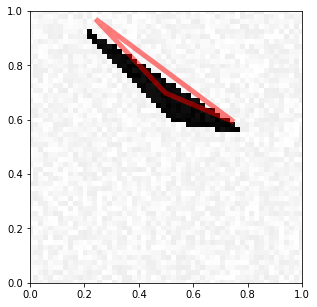

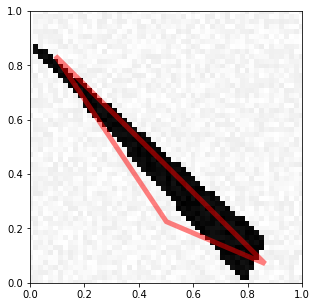

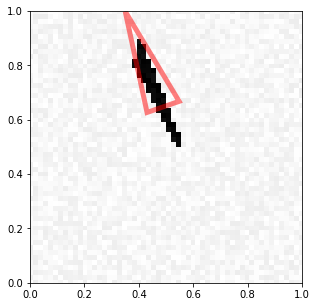

In [37]:
for i in range(10):
    visualize_prediction(X_test_r[i], recreate_features(regressor.predict(X_test_r[i].reshape(-1,72,72,1))))

Those results are not that good on test set.